# Import Tensorflow

In [0]:
!pip install tensorflow==2.0.0b1

     |████████████████████████████████| 87.9MB 21.8MB/s 
     |████████████████████████████████| 3.1MB 25.4MB/s 
     |████████████████████████████████| 501kB 42.2MB/s 
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0


In [0]:
!pip install tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 57kB/s 


# SPIT Imports

In [0]:
# imports
import numpy as np
import os

from importlib import reload
from pkg_resources import resource_filename
from google.colab import drive
import imageio

In [0]:
import tensorflow
tensorflow.__version__

'2.0.0-beta1'

In [0]:
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
!git clone https://github.com/pypeit/spit.git

Cloning into 'spit'...
remote: Enumerating objects: 166, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 850 (delta 111), reused 65 (delta 40), pack-reused 684
Receiving objects: 100% (850/850), 932.20 KiB | 3.13 MiB/s, done.
Resolving deltas: 100% (486/486), done.


In [0]:
%cd spit

/content/spit


In [0]:
!git checkout new_models

Branch 'new_models' set up to track remote branch 'new_models' from 'origin'.
Switched to a new branch 'new_models'


In [0]:
!git pull

Already up to date.


In [0]:
!python setup.py develop

running develop
running egg_info
creating spit.egg-info
writing spit.egg-info/PKG-INFO
writing dependency_links to spit.egg-info/dependency_links.txt
writing top-level names to spit.egg-info/top_level.txt
writing manifest file 'spit.egg-info/SOURCES.txt'
writing manifest file 'spit.egg-info/SOURCES.txt'
running build_ext
Creating /usr/local/lib/python3.6/dist-packages/spit.egg-link (link to .)
Adding spit 0.1.dev0 to easy-install.pth file
Installing spit_train script to /usr/local/bin
Installing spit_png script to /usr/local/bin
Installing spit_classify_image script to /usr/local/bin

Installed /content/spit
Processing dependencies for spit==0.1.dev0
Finished processing dependencies for spit==0.1.dev0


In [0]:
# imports
from importlib import reload

from spit import image_loader
from spit import labels as spit_l
from spit import preprocess as spit_p
from spit import classifier as c
from spit import utils
from spit import classify as spit_classify
from spit import io as spit_io

# Build DenseNet

In [0]:
import tensorflow as tf
from tensorflow import keras

In [0]:
print(tf.test.is_gpu_available())
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

True
Found GPU at: /device:GPU:0


In [0]:
# need to add compression to either block, transition, or both to get it to be BC

def dense_block(model):
  
  # 1x1 convolution bottleneck
  
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.ReLU())
  #### HYPERPARAMETERS: GROWTH RATE AND DROPOUT RATE ####
  model.add(keras.layers.Conv2D(growth_rate*filters, kernel_size=1))
  model.add(keras.layers.Dropout(rate=dropout_rate))
  
  # 3x3 dense convolution
  
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.ReLU())
  #### HYPERPARAMETER ####
  model.add(keras.layers.Conv2D(filters, kernel_size=3))
  #### HYPERPARAMETER ####
  model.add(keras.layers.Dropout(rate=dropout_rate))
  
  return

def transition_layer(model):
  model.add(keras.layers.BatchNormalization())       #   x = Batch_Normalization(x, training=self.training, scope=scope+'_batch1')
  model.add(keras.layers.ReLU())                     #   x = Relu(x)
  
  model.add(keras.layers.Conv2D(filters, kernel_size=1))
  
  model.add(keras.layers.Dropout(rate=dropout_rate)) #   x = Drop_out(x, rate=dropout_rate, training=self.training)
  
  model.add(keras.layers.AveragePooling2D(pool_size=(2,2), strides=2))
  return

In [0]:
#### DENSE NET ARCHITECTURE #####
#
# CONV --> BLOCK --> TRANSITION --> BLOCK --> TRANSITION --> BLOCK --> POOL --> SOFTMAX
#
# BLOCK:
# BatchNorm --> ReLu --> Conv (1x1) --> DropOut --> BatchNorm --> ReLu --> Conv (3x3) --> DropOut --> output
#

model = keras.Sequential()

# hyperparameters
filters = 64
dropout_rate = .2
theta = .5
growth_rate = 4

# add a conv layer
model.add(keras.layers.Conv2D(filters, kernel_size=7, strides=(2, 2), padding='valid', activation='relu', 
                            input_shape = (210, 650, 1)))

# pool like in tf simple implementation
model.add(keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid'))

# add block
dense_block(model)
# add transition
transition_layer(model)
# add block
dense_block(model)
# add transition
transition_layer(model)
# add block
dense_block(model)
# add pool
model.add(keras.layers.GlobalAveragePooling2D())
# add flatten
model.add(keras.layers.Flatten())

# Produce 0-1 probabilities with softmax
model.add(keras.layers.Dense(5, activation='softmax'))

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fake Data

In [0]:
x_train = np.random.random((100, 210, 650, 1))
train_labels = np.random.randint(5, size=(100, 1))

In [0]:
y_train = keras.utils.to_categorical(train_labels, num_classes=5)

In [0]:
 model.fit(
        x_train, 
        y_train, 
        epochs=5, 
        batch_size=6 
 )

Train on 100 samples
Epoch 1/5
 12/100 [==>...........................] - ETA: 2:54 - loss: 2.8118 - accuracy: 0.2500

KeyboardInterrupt: ignored

# Kast Training

In [0]:
os.environ['SPIT_PATH'] = "/content/drive/My Drive/Colab Notebooks/SPIT_DATA"
os.environ['SAVE_PATH'] = "/content/drive/My Drive/Colab Notebooks/"

In [0]:
label_dict = spit_l.kast_label_dict()
preproc_dict = spit_p.original_preproc_dict()
classify_dict = spit_l.kast_classify_dict(label_dict)

# kast = c.Classifier(label_dict, preproc_dict, classify_dict)

# methods

In [0]:
  os.environ['SPIT_PATH'] = "/content/drive/My Drive/Colab Notebooks/SPIT_DATA"
  os.environ['SAVE_PATH'] = "/content/drive/My Drive/Colab Notebooks/"

  # might need to add subset
  def _train(epochs, batch_size, subset_percent=None, train_images=None, train_labels=None, validation_data=None, steps_per_epoch=None, validation_freq=1, test_model=None, spit_path=os.getenv('SPIT_PATH'), save_path=os.getenv('SAVE_PATH')):
    """

    Trains the classifier with given images, labels, and training parameters.

    Parameters:

    :param epochs:
      Number of epochs of the training. 
      Must be an integer value.

    :param batch_size:
      Size of the training batches formed in the process. 
      Must be an integer value.

    :param save_path:
      Path to where the best model will be saved.

    :param train_images:
       Set of images for model to train on.
       Assume this is a numpy array with (batch_size, width, height, num_channels) as its dimensions.

    :param train_labels:
      Set of test labels corresponding to test images.
      Assume this is a rank 1 array with (batch_size, ) as its dimensions.

    :param validation_data:
      Data to be used for the validation set. 
      Assume this is a tuple with (images, labels) with same dimensions as train_images, train_labels.
      If None is specified, validation_data will be None.

    :param steps_per_epoch:
      Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch.
      Assume this is an integer value. If None is specified, this will be None.  

    :param validation_freq:
      Specifies how many training epochs to run before a new validation run is performed.
      Assume this is an integer value or a collection containing the epochs at which to run validation (ie [1,2,10]).

    :param test_model:
      An alternative choice for model to train on. Assume None.

    :param spit_path & param save_path:
      Path to the spit images and where the model will be saved respectively.
      ***Environmental variables must be set by caller or the path must be passed manually.***

    Returns:
    :returns history:
      Tensorflow History object containing loss and accuracy data over the training.

    """
    # choose the model
    if test_model is None:
      model = test_model
    else:
      model = test_model

    # if None is passed, then use the kast images
    if train_images is None or train_labels is None:
      # load training set
      train = np.load(os.path.join(spit_path, 'Kast', 'kast_train.npz'))
      train_images = train['images']
      train_labels = train['labels']

      # load validation set
      validate = np.load(os.path.join(spit_path, 'Kast', 'kast_validate.npz'))
      v_images = validate['images']
      v_labels = validate['labels']

      validation_data = (v_images, v_labels)

    # change to categorical and make subsets
    if validation_data is not None:
      valid_images, valid_labels = validation_data
      if subset_percent is not None:
        valid_images, valid_labels = split_array(valid_images, valid_labels, subset_percent)
      valid_labels = keras.utils.to_categorical(valid_labels, num_classes=len(label_dict))
      validation_data = (valid_images, valid_labels)

    if train_images is not None and train_labels is not None:
      if subset_percent is not None:
        train_images, train_labels = split_array(train_images, train_labels, subset_percent)
      train_labels = keras.utils.to_categorical(train_labels, num_classes=len(label_dict))

    # checkpoint to track best model
    checkpoint=keras.callbacks.ModelCheckpoint(save_path+'best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

    # train the model
    history = model.fit(
          train_images, 
          train_labels, 
          epochs=epochs, 
          batch_size=batch_size,
          validation_data=validation_data,
          steps_per_epoch=steps_per_epoch,
          validation_freq=validation_freq,
          callbacks=[checkpoint]
    )
    
    # save loss and accuracy data
    keys = history.history
    np.savez_compressed('history.npz', loss=keys['loss'], accuracy=keys['accuracy'], val_loss=keys['val_loss'], val_accuracy=keys['val_accuracy'])
    
    return history

  import math

  def split_array(images, labels, subset_percent):
    """
    Splits dataset based on a percentage value.

    Parameters:
    :param images:
      Images from a dataset to be trained on.
      4-D Numpy array with (batch_size, width, height, num_channels) as its dimensions.

    :param labels:
      Labels from a dataset to be trained on.
      Rank 1 Numpy array with (batch_size,) as its dimensions.

    :param subset_percent:
      Float value determining percentage of subset to remain.

    Returns:
    :returns split_images:
      Numpy array containing a fraction of the initial images parameter (batch_size*subset_percent)

    :returns split_labels:
      Numpy array containing a fraction of the initial labels parameter (batch_size*subset_percent)
    """
    split_images = []
    split_labels = []
    
    # get all unique labels
    uni_lbls = np.unique(labels)
    
    # find all instances of labels and subset based on that
    for uni_lbl in uni_lbls:
      idx = np.where(labels==uni_lbl)[0]
      # 0 : len(idx)*subset_percent
      lower = 0
      upper = int(math.floor(len(idx)*subset_percent))
      split_images.extend(images[idx[lower:upper]])
      split_labels.extend(labels[idx[lower:upper]])
    return np.asarray(split_images), np.asarray(split_labels)

In [0]:
def load_model(file_name, file_path):
  '''
  :param file_name: The model name. Should be a string 'blah.h5'
         file_path: The path that the user would like to save to.
                    In the form of 'blah/foo/bar/'
  :return: the model loaded
  '''

  loaded_model = keras.models.load_model(file_path+file_name)
  return loaded_model

In [0]:
def predict_one_image(images, model):
  
  ishape = list(images.shape)
  images = images.reshape(ishape+[1])
  
  prediction = model.predict(images)
  return prediction

In [0]:
def get_prediction(images_array, model, use_heuristics=False):
    """

    Returns
    -------
    value : int
      Most common value or -1, if it is not the majority
    results : list
      All of the values for each flipped image
    """
    from collections import Counter
    
    # Classify all 4
    results = []
    results.append(np.argmax(predict_one_image(images_array[0:1,:], model)))
    results.append(np.argmax(predict_one_image(images_array[1:2,:], model)))
    results.append(np.argmax(predict_one_image(images_array[2:3,:], model)))
    results.append(np.argmax(predict_one_image(images_array[3:4,:], model)))
    resultsCounter = Counter(results)

    # Heuristics
    if use_heuristics:
        if results.count(2) >= 2:
            value = 2
        elif results.count(1) >= 2:
            value = 1
        else:
            value, _ = resultsCounter.most_common()[0]
    else:  # Majority rules
        value, n_occur = resultsCounter.most_common()[0]
        if n_occur <= 2:
            value = -1
    # Return
    return value, results

In [0]:
from matplotlib import pyplot as plt

def display_training_trends(history, key1, key2, title='training'):
    """
    Display the graphs of loss/accuracy during training
    
    :param history:
        Tensorflow History object or Numpy Decompressed File object.
    :param key1:
        Key contained within history object that user can provide to plot as compared with other keys.
        Assume key is a string contained in the history object.
    :param key2:
        Key contained within history object that user can provide to plot as compared with other keys.
        Assume key is a string contained in the history object.
    :param title:
        Title of the graph. If caller doesn't specify, use default of 'training'.
    """
    h = None
    if  'tensorflow' in str(type(history)):
      h = history.history
      print("h is history.history")
    else:
      h = history
      print("h is history")
    print(h)
    # make subplots
    fig, ax1 = plt.subplots()

    # set title of graph
    plt.title(title) 

    # set x label
    color = 'tab:red'
    ax1.set_xlabel('epochs')

    # plot first key
    ax1.set_ylabel(key1, color=color)  # we already handled the x-label with ax1
    lns1 = ax1.plot(h[key1], color=color, label = key1) # maybe improve labeling 
    ax1.tick_params(axis='y')

    color = 'tab:blue'
    legend_loc = 'best'

    # instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()  

    # plot second key
    ax2.set_ylabel(key2, color=color)  # we already handled the x-label with ax1
    lns2 = ax2.plot(h[key2], color=color, label = key2)
    ax2.tick_params(axis='y') #labelcolor=color

    # legend for two axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=legend_loc)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

# Experiments

In [0]:
# test all methods working, 1.1, 100 epochs
history = _train(epochs=3, batch_size=6, subset_percent=0.01, test_model=model)

Train on 155 samples, validate on 35 samples
Epoch 1/3
155/155 [==============================] - 3s 18ms/sample - loss: 0.1421 - accuracy: 0.9742 - val_loss: 7.3406 - val_accuracy: 0.3714
Epoch 2/3
155/155 [==============================] - 2s 13ms/sample - loss: 0.0708 - accuracy: 0.9677 - val_loss: 5.2303 - val_accuracy: 0.6000
Epoch 3/3
155/155 [==============================] - 2s 13ms/sample - loss: 0.1345 - accuracy: 0.9613 - val_loss: 2.0834 - val_accuracy: 0.7143


h is history


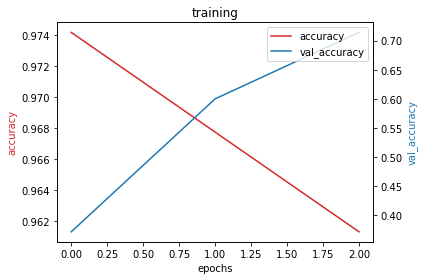

In [0]:
# load history, make graph of accuracy vs. validation accuracy
# load history still
history = np.load('history.npz')
str(type(history))
display_training_trends(history, key1='accuracy', key2='val_accuracy')

h is history.history
{'loss': [0.14205214455235568, 0.07079402762615393, 0.13445983527260155], 'accuracy': [0.9741936, 0.9677419, 0.9612903], 'val_loss': [7.340566403525216, 5.230261066981725, 2.083380366223199], 'val_accuracy': [0.37142858, 0.6, 0.71428573]}


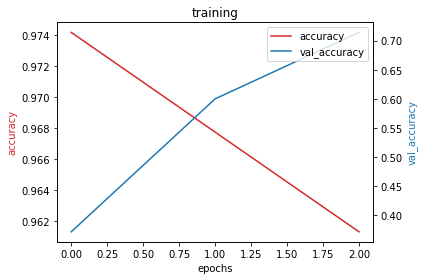

In [0]:
display_training_trends(history, key1='accuracy', key2='val_accuracy')

In [0]:
# do final evaluation on test data

best_model = keras.models.load_model(os.environ['SAVE_PATH']+'best_model.h5')
test = np.load(os.path.join(os.environ['SPIT_PATH'], 'Kast', 'kast_test.npz'))
test_images = test['images']
test_labels = test['labels']
test_labels = keras.utils.to_categorical(test_labels, num_classes=len(label_dict))
best_model.evaluate(test_images, test_labels) 

4840/4840 [==============================] - 10s 2ms/sample - loss: 3.0653 - accuracy: 0.6748


[3.0652541778069673, 0.67479336]

# Run train and test

In [0]:
# full train, 1.1, 100 epochs
history = _train(epochs=100, batch_size=6, test_model=model)

W0731 20:34:14.287537 139970689517440 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 15540 samples, validate on 3880 samples
Epoch 1/100
15540/15540 [==============================] - 195s 13ms/sample - loss: 0.3477 - accuracy: 0.8950 - val_loss: 0.1821 - val_accuracy: 0.9557
Epoch 2/100
15540/15540 [==============================] - 185s 12ms/sample - loss: 0.1231 - accuracy: 0.9623 - val_loss: 2.2725 - val_accuracy: 0.7487
Epoch 3/100
15540/15540 [==============================] - 185s 12ms/sample - loss: 0.1008 - accuracy: 0.9721 - val_loss: 0.0440 - val_accuracy: 0.9910
Epoch 4/100
15540/15540 [==============================] - 184s 12ms/sample - loss: 0.0744 - accuracy: 0.9784 - val_loss: 0.2489 - val_accuracy: 0.9242
Epoch 5/100
15540/15540 [==============================] - 184s 12ms/sample - loss: 0.0654 - accuracy: 0.9808 - val_loss: 0.0383 - val_accuracy: 0.9907
Epoch 6/100
15540/15540 [==============================] - 185s 12ms/sample - loss: 0.0668 - accuracy: 0.9819 - val_loss: 0.0403 - val_accuracy: 0.9884
Epoch 7/100
15540/15540 [==============

Exception ignored in: <bound method NpzFile.__del__ of <numpy.lib.npyio.NpzFile object at 0x7f4cb1992dd8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/numpy/lib/npyio.py", line 230, in __del__
    self.close()
  File "/usr/local/lib/python3.6/dist-packages/numpy/lib/npyio.py", line 225, in close
    self.fid.close()
OSError: [Errno 107] Transport endpoint is not connected
Exception ignored in: <bound method NpzFile.__del__ of <numpy.lib.npyio.NpzFile object at 0x7f4cb19925f8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/numpy/lib/npyio.py", line 230, in __del__
    self.close()
  File "/usr/local/lib/python3.6/dist-packages/numpy/lib/npyio.py", line 225, in close
    self.fid.close()
OSError: [Errno 107] Transport endpoint is not connected


h is history


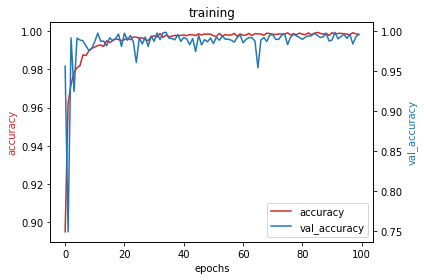

In [0]:
# load history, make graph of accuracy vs. validation accuracy
h = np.load('history.npz')
display_training_trends(h, key1='accuracy', key2='val_accuracy')

In [0]:
# load best model for evaluation
best_model = keras.models.load_model(os.environ['SAVE_PATH']+'best_model.h5')

W0801 19:57:40.582382 140149520967552 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# load test data
test = np.load(os.path.join(os.environ['SPIT_PATH'], 'Kast', 'kast_test.npz'))

In [0]:
# parse test data
test_images = test['images']
test_labels = test['labels']

In [0]:
# prepare labels for evaluation
test_labels = keras.utils.to_categorical(test_labels, num_classes=len(label_dict))

In [0]:
# run evaluation
best_model.evaluate(test_images, test_labels) 

4840/4840 [==============================] - 10s 2ms/sample - loss: 0.0563 - accuracy: 0.9915


[0.05634400943170428, 0.9915289]

# Confusion Matrix

In [0]:
# make confusion matrix
from sklearn.metrics import confusion_matrix

In [0]:
values=[]
results=[]

In [0]:
for image in test_images:
  print(image)
  flip_images = spit_p.flips(image)
  images_array = np.array(list(flip_images))
  value, result = get_prediction(images_array, best_model, use_heuristics=True)
  values.append(value)
  results.append(result)

[[[ 0]
  [ 0]
  [ 0]
  ...
  [54]
  [54]
  [ 0]]

 [[ 0]
  [ 0]
  [ 0]
  ...
  [54]
  [53]
  [ 0]]

 [[ 0]
  [ 0]
  [ 0]
  ...
  [54]
  [53]
  [ 0]]

 ...

 [[ 0]
  [ 0]
  [ 0]
  ...
  [51]
  [50]
  [ 0]]

 [[ 0]
  [ 0]
  [ 0]
  ...
  [50]
  [50]
  [ 0]]

 [[ 0]
  [ 0]
  [ 0]
  ...
  [50]
  [50]
  [ 0]]]


TypeError: ignored

In [0]:
val_true = test['labels']

In [0]:
# import scikit learn confusion matrix
# load the best model
# load the test data
# use model.predict and save the values into predictions 
predictions = best_model.predict(test_images)
# call confusion matrix with true_labels, predictions

In [0]:
cm = confusion_matrix(test_labels, predictions)

ValueError: ignored

In [0]:
print(predictions)

[[2.85231066e-16 1.79409751e-17 3.06095007e-14 1.49503822e-25
  1.00000000e+00]
 [4.58994449e-16 1.26381336e-17 2.18457691e-14 8.49186578e-26
  1.00000000e+00]
 [2.35157878e-12 1.23956607e-12 3.07840246e-11 1.83119176e-19
  1.00000000e+00]
 ...
 [1.80569292e-11 1.00000000e+00 6.79828527e-10 1.08981726e-15
  5.19909981e-18]
 [1.37923174e-13 1.00000000e+00 2.29849598e-10 1.33276689e-17
  9.08066113e-21]
 [2.39914425e-12 1.00000000e+00 1.75397241e-09 1.19341822e-17
  4.30210459e-19]]


In [0]:
print(test_labels)

[4 4 4 ... 1 1 1]


In [0]:
maxElement = np.amax(predictions[0])
maxIndex = np.where(predictions[0] == maxElement)
print(maxElement)
print(maxIndex[0][0])


1.0
4


In [0]:
pred = []
for p in enumerate(predictions):
  # index of loop
  i = p[0]
  # particular prediction array for this image
  p_array = p[1]
  # find and append prediction
  maxIndex = np.where(p_array == np.amax(p_array))
  pred.append(maxIndex[0][0])

In [0]:
cm = confusion_matrix(test_labels, pred)

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
#     # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [0]:
# plot_confusion_matrix(test_labels, pred, )
print(label_dict)
classes = []
for label in label_dict:
  if '_label' in label:
    label = label.replace('_label','')
  classes.append(label)
print(classes)
# classes = {x.replace('_label', '') for x in classes}
# print(classes)

OrderedDict([('bias_label', 0), ('science_label', 1), ('standard_label', 2), ('arc_label', 3), ('flat_label', 4)])
['bias', 'science', 'standard', 'arc', 'flat']


Confusion matrix, without normalization
[[968   0   0   0   0]
 [  0 960   8   0   0]
 [  0  31 937   0   0]
 [  0   0   0 968   0]
 [  2   0   0   0 966]]


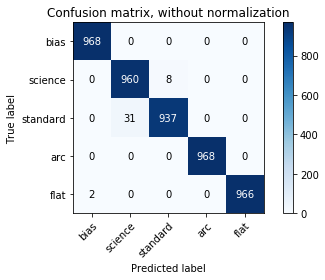

In [0]:
plot_confusion_matrix(test_labels, pred, classes)

In [0]:
flip_images = []
for image in test_images:
  flip_images.extend(flips(image.astype(np.uint8)))
print(flip_images)

finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finished flip
finish

KeyboardInterrupt: ignored

In [0]:
def horizontal_flip(image_array):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1]

In [0]:
def flips(image_array, rotations=4):
  flips = []
  for i in range(rotations):
    image_array = horizontal_flip(image_array)
    flips.extend(image_array)
  print("finished flip")
  return flips